## **download library and install library**

In [ ]:
!pip install torch==1.10.0+cu102 torchvision==0.11.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu102/torch1.10.0/index.html
!pip install mmdet==2.17.0
!pip install icevision[all]
!pip install fastbook
!pip install gradio
!pip install icedata
!pip install progressbar2
!pip install tqdm

In [ ]:
import json
import ast
import pandas as pd
import os.path as op
from pathlib import Path
from PIL import Image
from icevision.models import *
from icevision.all import *
import icedata
import PIL, requests
import torch
from torchvision import transforms
import gradio as gr
from fastbook import *
from fastai.vision.all import *
import os.path as op
import pandas as pd
from icevision.all import *


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Object detection ด้วย IceVision**

ใน Section นี้เราจะใช้ไลบรารี่ Icevision ในการสร้างโมเดล Object detection กัน

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/train_labels.csv")
df.rename(columns={"class": "label"}, inplace=True)

In [ ]:
df.to_csv("/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/train_annotation.csv", index=False)

In [ ]:
df.head()

filename  width  height   label  xmin  ymin  xmax  ymax
0   B_C (1).jpg   1140    1520  mangda   226   431   884  1252
1  B_C (10).jpg    720     960  mangda   202   525   402   754
2  B_C (10).jpg    720     960  mangda   339   122   631   408
3  B_C (10).jpg    720     960  mangda    69   591   199   744
4  B_C (11).jpg    720     960  mangda    30   102   695   815

In [ ]:
template_record = ObjectDetectionRecord()

class YoloSmallDataset(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
        self.df = pd.read_csv("/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/train_annotation.csv")
        self.class_map = ClassMap(list(self.df['label'].unique()))

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.filename

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(op.join("/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/", "train", o.filename))
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)

        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

In [ ]:
parser = YoloSmallDataset(template_record)
train_records, valid_records = parser.parse()

  0%|          | 0/844 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/374 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: F_C (21).jpg) - Clipping bbox xmax from 507 to image width 0 (Before: <BBox (xmin:54, ymin:15, xmax:507, ymax:560)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-SUCCESS - (record_id: F_C (21).jpg) - Clipping bbox ymax from 560 to image height 0 (Before: <BBox (xmin:54, ymin:15, xmax:0, ymax:560)>) | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-FAIL - (record_id: F_C (21).jpg) - Cannot auto-fix coordinates: <BBox (xmin:54, ymin:15, xmax:0, ymax:0)>
	x_min:54 is greater than or equal to x_max:0
	y_min:15 is greater than or equal to y_max:0 | icevision.utils.logger_utils:autofix_log:17
AUTOFIX-REPORT - (record_id: F_C (21).jpg) Removed annotation with index: 0, for more info check the AUTOFIX-FAIL messages above | icevision.core.record:autofix:50
AUTOFIX-SUCCESS - (record_id: F_C (28).jpg) - Clipping bbox xmax from 279 to image width 0 (Before: <BBox (xmin:53, ymin:113, xmax:279, ymax:405)>) | icevision.utils.logger_utils:autofix_log:17
AUTOF

In [ ]:
len(train_records), len(valid_records)

(299, 75)

In [ ]:
model_type = models.mmdet.retinanet
backbone = model_type.backbones.resnet50_fpn_1x

In [ ]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=224, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(224), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

In [ ]:
train_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=2, shuffle=True)
valid_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=2, shuffle=False)

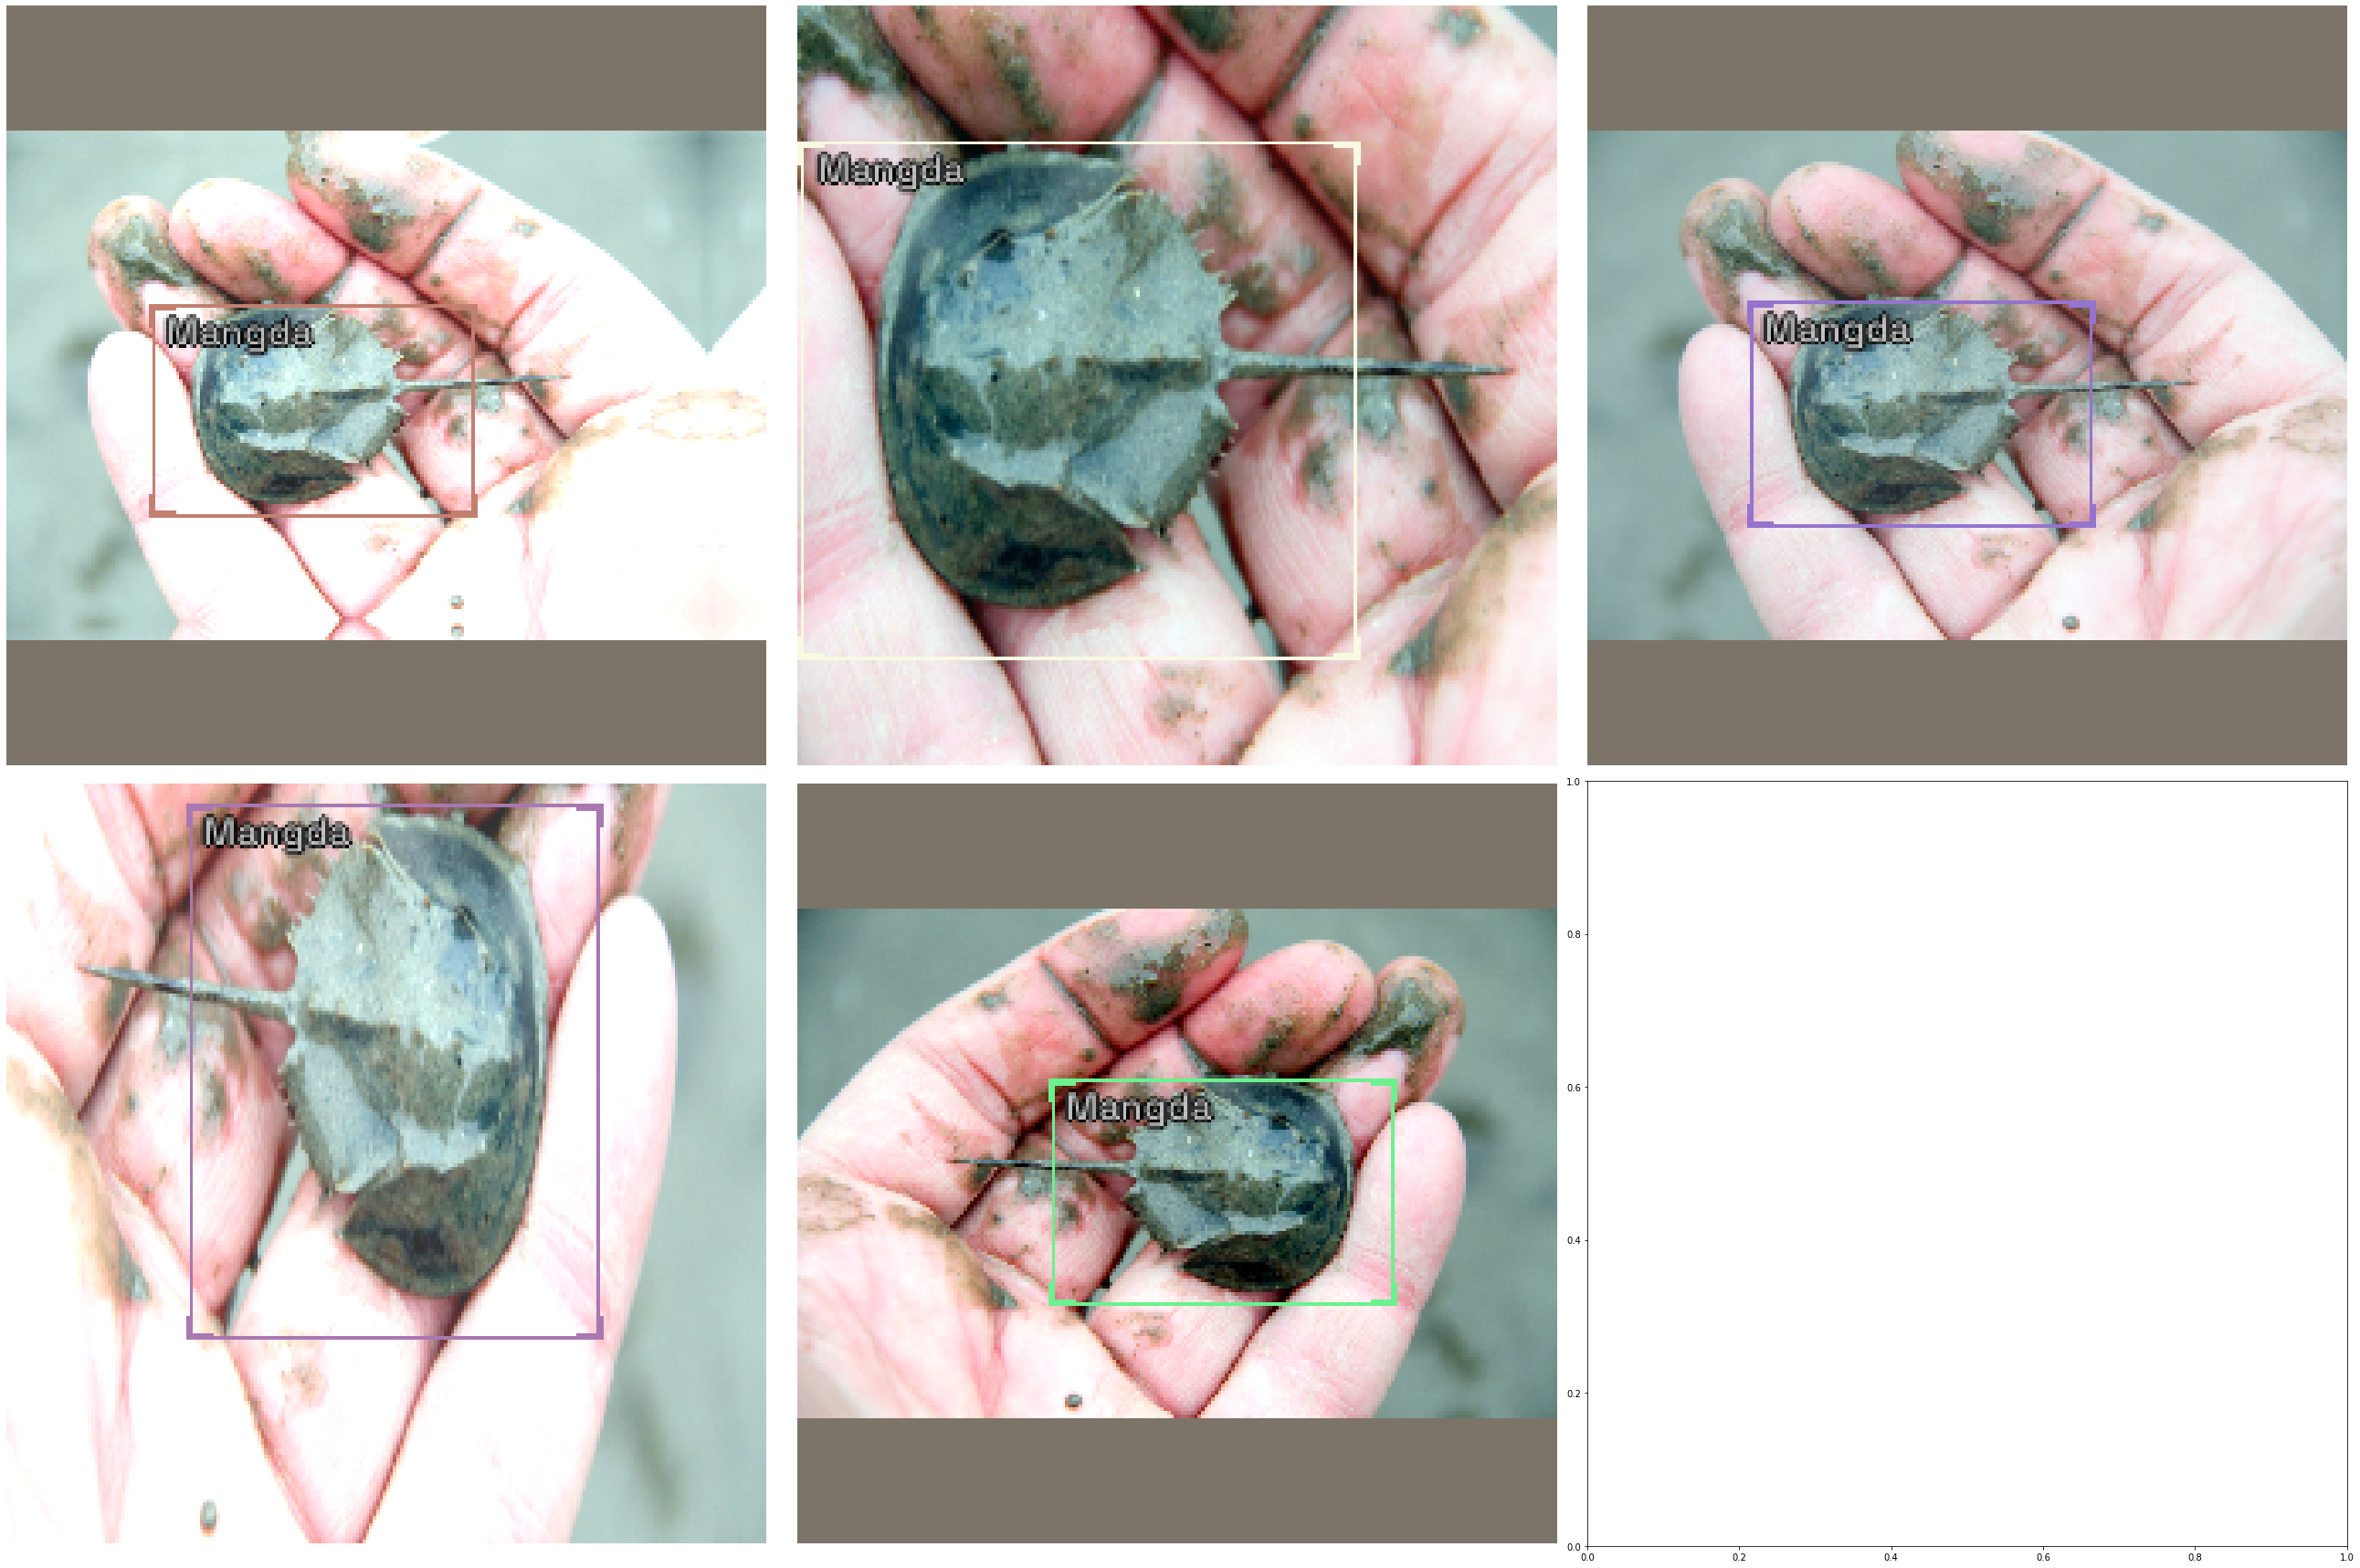

In [ ]:
samples = [train_ds[10] for _ in range(5)]
show_samples(samples, ncols=3)

In [ ]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map))

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learner = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


SuggestedLRs(valley=3.630780702224001e-05)

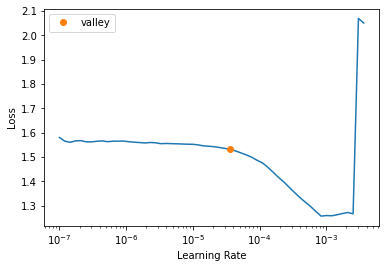

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(80, 3e-03, freeze_epochs=1, )

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


In [ ]:
m = ClassMap(list(df['label'].unique()))
m.get_classes()

['background', 'mangda']

In [ ]:
cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_OBJ

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_OBJ


In [ ]:
# เซฟโมเดลด้วยคำสั่ง `save_icevision_checkpoint`
checkpoint_path = "mangda_det_160.pth"
save_icevision_checkpoint(
    model, 
    model_name='mmdet.retinanet', 
    backbone_name='resnet50_fpn_1x',
    classes=m.get_classes(),
    img_size=224,
    filename=checkpoint_path,
    meta={"icevision_version": "0.12.0"}
)

## **Prediction**

ลองใช้โมเดลทำนายผลใน validation dataset `valid_ds`

In [ ]:
# โหลดโมเดลที่เซฟมาเพื่อทำนายผลใน validation set
model_loaded = model_from_checkpoint("/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_OBJ/mangda_det_240.pth")

load checkpoint from local path: /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_OBJ/mangda_det_240.pth


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/builder.py:17: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2022-06-13 10:53:59,844 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'torchvision://resnet50'}
2022-06-13 10:53:59,845 - mmcv - INFO - load model from: torchvision://resnet50
2022-06-13 10:53:59,850 - mmcv - INFO - load checkpoint from torchvision path: torchvision://resnet50
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2022-06-13 10:54:00,786 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2022-06-13 10:54:00,818 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2022-06-13 10:54:00,880 - mmcv - INFO - initialize RetinaHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01, 'override': {'type': 'Normal', 'name': 'retina_cls', 'std': 0.01, 'bias_prob': 0.01}}
2022-06-13 10:54:00,923 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-06-13 10:54:00,927 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-06-13 10:54:00,930 - mmcv - INFO - 
backbone.bn1.bias - torch.Size([64]): 
PretrainedInit: load from torchvision://resnet50 
 
2022-06-13 10:54:00,933 - mmcv - INFO - 
backbone.layer1.0.conv1.weight - torch.Size([64

In [ ]:
model = model_loaded['model']
model_type = model_loaded["model_type"]
backbone = model_loaded["backbone"]
class_map = model_loaded["class_map"]
img_size = model_loaded["img_size"]
model_type, backbone, class_map, img_size

(<module 'icevision.models.mmdet.models.retinanet' from '/usr/local/lib/python3.7/dist-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 <ClassMap: {'background': 0, 'mangda': 1}>,
 224)

In [ ]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad((img_size,img_size)), tfms.A.Normalize()])

In [ ]:
cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images


In [ ]:
path_to_image_folder = "/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/test"
img_files = get_image_files(path_to_image_folder)

In [ ]:
img_files[0:4]

(#4) [Path('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/test/B_C (16).jpg'),Path('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/test/B_C (17).jpg'),Path('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/test/B_C (18).jpg'),Path('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/images/test/B_C (30).jpg')]

In [ ]:
device=next(model.parameters()).device
device

device(type='cpu')

In [ ]:
import torch

import torchvision.transforms.functional as fn

from PIL import Image

from torchvision.transforms.functional import crop
import cv2
import numpy as np

In [ ]:
img = PIL.Image.open(img_files[4])
img

In [ ]:
pred_dict

In [ ]:
img = PIL.Image.open(img_files[4])

pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)
pred_dict['img']

In [ ]:
pred_dict['height']

720

In [ ]:
learn_BF = load_learner('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_back_front/VGG16_fastai.pkl')
learn_B = load_learner('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_back/densenet201_fastai.pkl')
learn_F = load_learner('/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/model_front/resnext50_fastai.pkl')

#Path directory files
directory_T = '/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/img_split/test/Tachypleus_gigas/'
directory_C ='/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/img_split/test/Carcinoscorpius_rotundicauda/'

#Class labels
T= 'Tachypleus_gigas'
C = 'Carcinoscorpius_rotundicauda'

In [ ]:
for i in range(len(pred_dict['detection']['bboxes'])):
  predict = []
  label = []
  pre = pred_dict['detection']['bboxes'][i-1]
  BBox_tensor = pre.to_tensor()
  BBox_list= BBox_tensor.tolist()
  # Setting the points for cropped image
  left = int(BBox_list[0])
  top = int(BBox_list[1])
  right = int(BBox_list[2])
  bottom = int(BBox_list[3])

 
  # Cropped image of above dimension
  # (It will not change original image)
  im1 = img.crop((left, top, right, bottom))
 
# Shows the image in image viewer
  im1.show()
  im1.resize((224,224))
  trans = transforms.ToPILImage()
  trans1 = transforms.ToTensor()
  im1 = trans(trans1(im1))
  im2 = np.array(im1)
  Pre_BF = learn_BF.predict(im2)[0]
  if Pre_BF == 'front' :# predict back or front
        Pre_F = learn_F.predict(im2)
        classes = ['Carcinoscorpius_rotundicauda', 'Tachypleus_gigas']
        prop_F = Pre_F[2].max()
        prop_float = prop_F.item()
        if prop_float > 0.6 : #weighrt predict 
          print('class:',Pre_F[0], ",accuracy =", '%.3f' %prop_float)
          predict.append(Pre_F[0])
        else:
          classes.remove(Pre_F[0])
          predict.append(classes[0])
          print('class:',classes[0], ",accuracy =", '%.3f' %prop_float)
  else:
        Pre_B = learn_B.predict(im2)
        prop_B = Pre_B[2].max()
        prop_float = prop_B.item()
        classes = ['Carcinoscorpius_rotundicauda', 'Tachypleus_gigas']
        if prop_float > 0.6 :
          print('class:',Pre_B[0], ",accuracy =", '%.3f' %prop_float)
          predict.append(Pre_B[0])
        else:
          classes.remove(Pre_B[0])
          predict.append(classes[0])
          print('class:',classes[0], ",accuracy =", '%.3f' %prop_float)

## **multi images**

In [ ]:
cd /content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/result1_obj_detection

/content/gdrive/MyDrive/bata_Horsehoe_Crab_classiflication/result1_obj_detection


In [ ]:
from tqdm import tqdm
from time import sleep

In [ ]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad((img_size,img_size)), tfms.A.Normalize()])
num_img = 1
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files[0:5]]
Pre_imgs_array = []
predict = []
for img in tqdm(imgs_array):
  pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.7)
  print("ภาพที่ %.2f" %num_img)
  img_out = img
  img_out = np.array(img_out)

  for i in tqdm(range(len(pred_dict['detection']['bboxes']))):
    pre = pred_dict['detection']['bboxes'][i-1]
    BBox_tensor = pre.to_tensor()
    BBox_list= BBox_tensor.tolist()
    # Setting the points for cropped image
    left = int(BBox_list[0])
    top = int(BBox_list[1])
    right = int(BBox_list[2])
    bottom = int(BBox_list[3])

    # crop image
    im1 = img.crop((left, top, right, bottom))
  

    # im1.show()
    im1.resize((224,224))
    trans = transforms.ToPILImage()
    trans1 = transforms.ToTensor()
    im1 = trans(trans1(im1))
    im2 = np.array(im1)
    Pre_BF = learn_BF.predict(im2)[0]
    
    if Pre_BF == 'front' :# predict back or front
          Pre_F = learn_F.predict(im2)
          classes = ['Carcinoscorpius_rotundicauda', 'Tachypleus_gigas']
          prop_F = Pre_F[2].max()
          prop_float = prop_F.item()
          if prop_float > 0.5 : #weight predict 
            print('class:',Pre_F[0], ",accuracy =", '%.3f' %prop_float)
            predict.append(Pre_F[0])
            # Draw draw boxes
            xmin = int(BBox_list[0])
            ymin = int(BBox_list[1])
            xmax = int(BBox_list[2])
            ymax = int(BBox_list[3])
            cv2.rectangle(img_out, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
            cv2.putText(img_out, 
                   Pre_F[0], 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * int(pred_dict['height']), 
                    (255,0,0), 2)
            
          else:
            classes.remove(Pre_F[0])
            predict.append(classes[0])
            print('class:',classes[0], ",accuracy =", '%.3f' %prop_float)
            # Draw draw boxes
            xmin = int(BBox_list[0])
            ymin = int(BBox_list[1])
            xmax = int(BBox_list[2])
            ymax = int(BBox_list[3])
            cv2.rectangle(img_out, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
            cv2.putText(img_out, 
                   classes[0], 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * int(pred_dict['height']), 
                    (255,0,0), 2)

    else:
          Pre_B = learn_B.predict(im2)
          prop_B = Pre_B[2].max()
          prop_float = prop_B.item()
          classes = ['Carcinoscorpius_rotundicauda', 'Tachypleus_gigas']
          if prop_float > 0.5 :#weight predict 
            print('class:',Pre_B[0], ",accuracy =", '%.3f' %prop_float)
            predict.append(Pre_B[0])
            # Draw draw boxes
            xmin = int(BBox_list[0])
            ymin = int(BBox_list[1])
            xmax = int(BBox_list[2])
            ymax = int(BBox_list[3])
            cv2.rectangle(img_out, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
            cv2.putText(img_out, 
                   Pre_B[0], 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * int(pred_dict['height']), 
                    (255,0,0), 2)

          else:
            classes.remove(Pre_B[0])
            predict.append(classes[0])
            print('class:',classes[0], ",accuracy =", '%.3f' %prop_float)
            # Draw draw boxes
            xmin = int(BBox_list[0])
            ymin = int(BBox_list[1])
            xmax = int(BBox_list[2])
            ymax = int(BBox_list[3])
            cv2.rectangle(img_out, (xmin,ymin), (xmax,ymax), (255,0,0), 3)
            cv2.putText(img_out, 
                   classes[0], 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * int(pred_dict['height']), 
                    (255,0,0), 2)
          sleep(.01)

  img_out = Image.fromarray(img_out)
  display(img_out)

  Pre_imgs_array.append(img_out)
  img_out = img_out.save("prediction " + str(num_img) + '.png')
  num_img = num_img +1
  sleep(0.001)

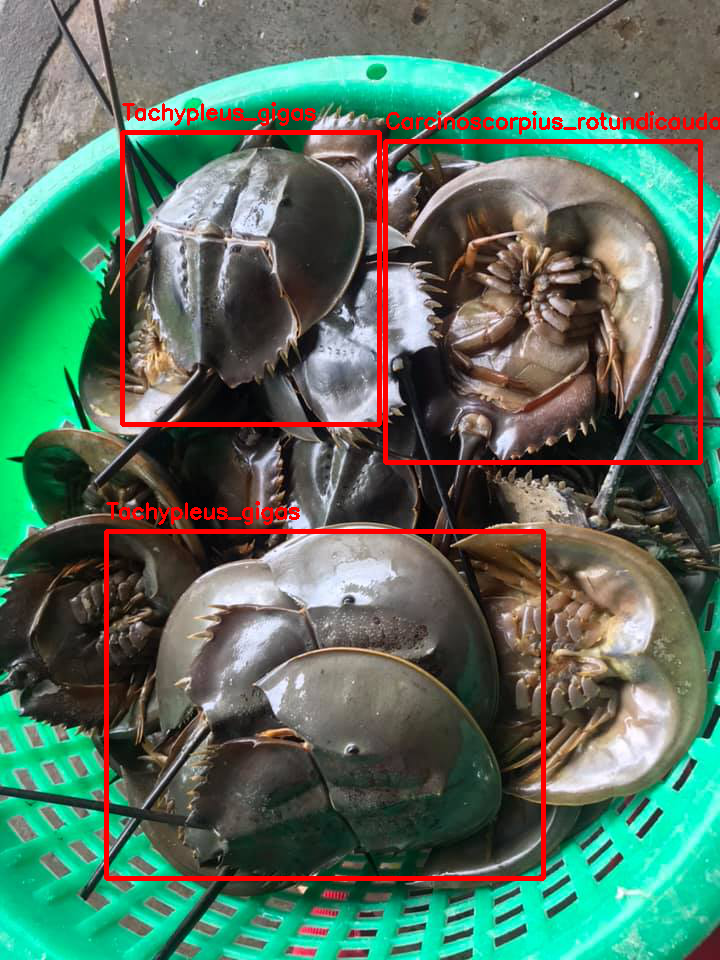

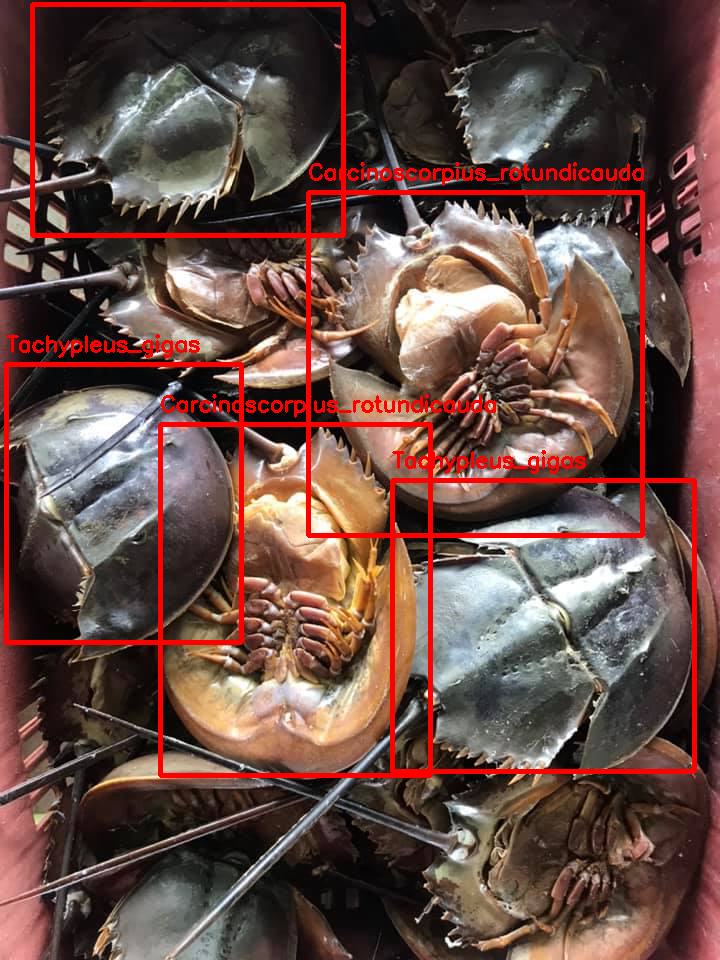

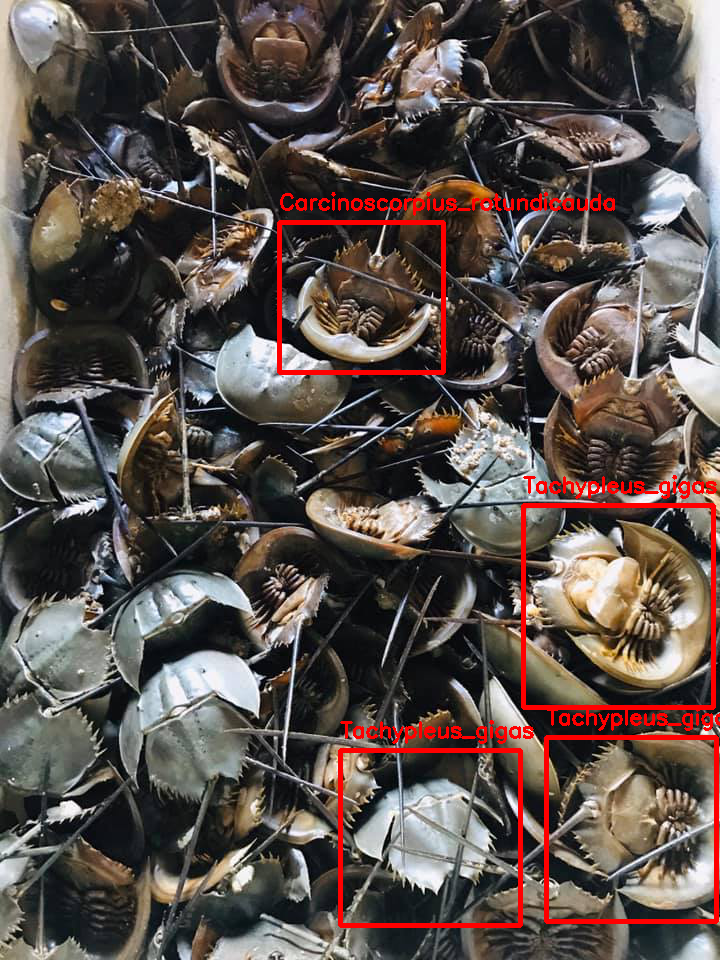

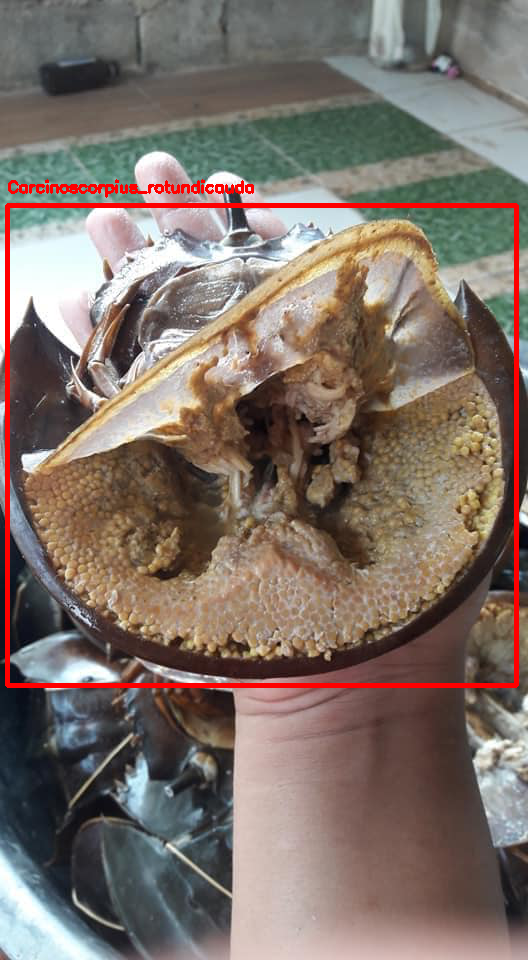

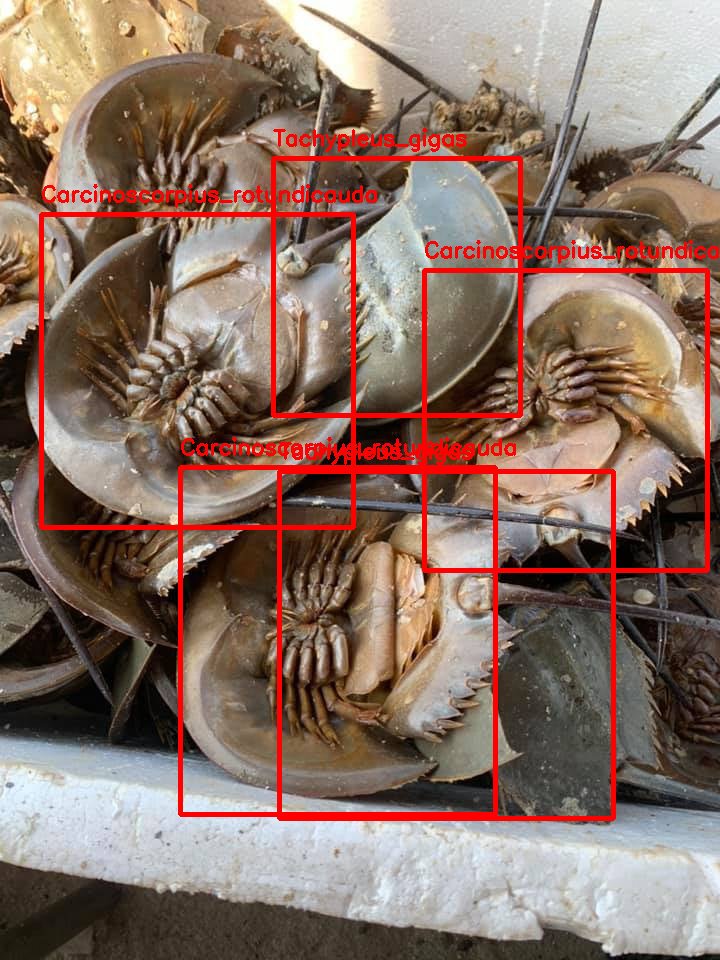

In [ ]:
for img in Pre_imgs_array:
  display(img)

# Create a dataset
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=16, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

In [ ]:
# Create a dataset
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

# Batch Inference
infer_dl = model_type.infer_dl(infer_ds, batch_size=1, shuffle=True)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


In [ ]:
device=next(model.parameters()).device
device

device(type='cpu')

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


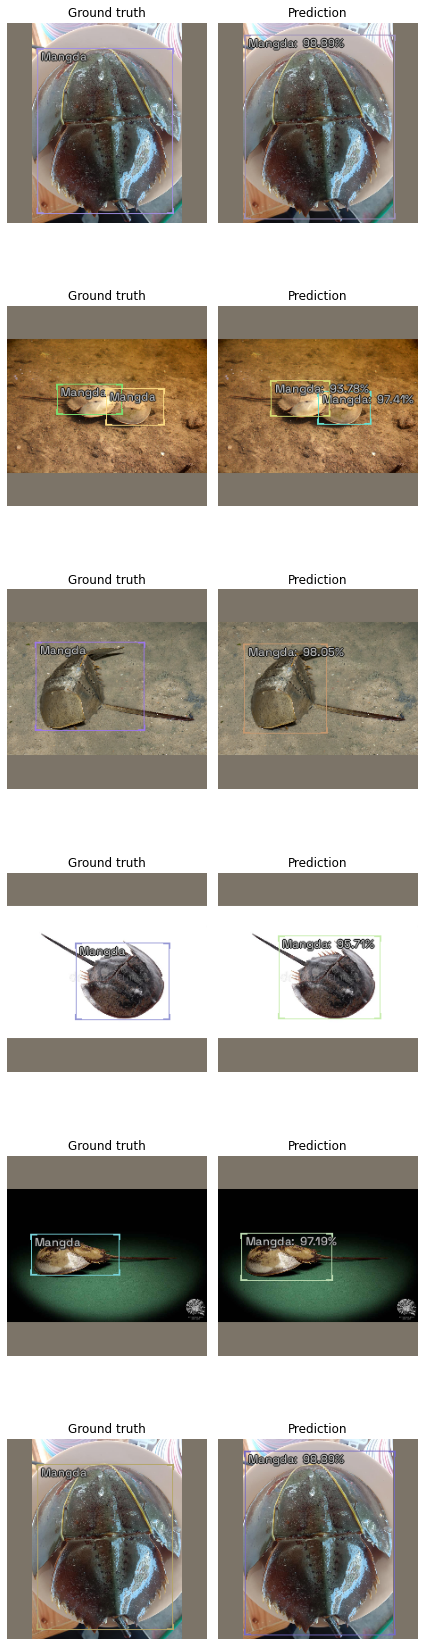

In [ ]:
model_type.show_results(model_loaded["model"], valid_ds, detection_threshold=0.6)